In [1]:
import sklearn
from sklearn import model_selection
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from log_regression import test, DPLogisticRegression
from ChoiceMaker import ChoiceMaker, DTChoice
import graphviz

In [2]:
#train_set
#def gen_binary_data(domain, nrow, seed):
ncol = 7
nrow = 1000
seed=12345
y_ratio=0.4
def gen_data(low, high, ncol, nrow, y_ratio, seed=12345, prng=None):
    """Generates an array containing a binary output and inputs drawn 
    from Gaussians. The output is the last column of the array
    and the inputs are the other columns. The inputs are conditionally
    independent of each other given the output. Thus, input at column i
    for output value j are drawn from a normal with mean mu_ij and 
    sigma_ij. Furthermore, we force sigma_ij = sigma_i with no dependence
    on j because this assumption allows us to derive logistic regression
    as the best fitting algorithm. We draw sigma_i and mu_ij randomly.
    We ensure sigma_i is at most one-quarter of high-low to ensure the
    Gaussian will mostly fit in the [low, high] interval.
    
    Parameters
    ----------

    low: lower bound on an input value
    
    high: upper bound on an input value
    
    ncol: number of inputs of the dataset
    
    nrow: number of rows in the dataset
    
    y_ratio: fraction of rows that take value 0 on the output column
    
    seed: seed value to use. Default: 12345
    
    prng: random number generator; can be called in addition to seed or 
    """
    if(prng == None):
        prng = np.random.RandomState(seed)
    sigmas = prng.uniform(0, (high-low)/6, ncol)
    s1 = int(y_ratio*nrow)
    s2 = nrow-s1
    def gen_col(sigma, sz):
        mu = prng.uniform(low+3*sigma, high-3*sigma)
        ans = prng.normal(mu, sigma, sz)
        c = (ans < low).sum()
        while(c > 0):
            ans[ans < low] = prng.normal(mu, sigma, c)
            c = (ans < low).sum()
        c = (ans > high).sum()
        while(c > 0):
            ans[ans > high] = prng.normal(mu, sigma, c)
            c = (ans > high).sum()
        return ans
    P1 = np.array([gen_col(s, s1) for s in sigmas] + [np.zeros(s1)]).T
    P2 = np.array([gen_col(s, s2) for s in sigmas] + [np.ones(s2)]).T
    A = np.concatenate((P1, P2))
    return A

In [3]:
epsilon=.5
low=0
high=1
ncol=7
nrow=100
pct=0.4
C=1
def gen_test(epsilon, ncol, nrow, pct=0.5, reps=10, low=0, high=5, seed=12345):
    G = gen_data(low, high, ncol, 2*nrow, pct, seed)
    X = G[:, 0:ncol]
    y = G[:, ncol]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5)
    K = high*np.sqrt(ncol)
    ans = 0
    for x in range(0, reps):
        plogit = DPLogisticRegression(epsilon, K, C, fit_intercept=True)
        plogit = plogit.fit(X_train, y_train)
        ans += plogit.score(X_test, y_test)
    return ans/reps

In [4]:
gen_test(2, 2, 1000, seed=12345)

0.9967

In [5]:
xrange2 = [2,7,70,170,270,400,700]
ys2 = [gen_test(2, x, 1000) for x in xrange2]

In [6]:
ys2

[0.9959000000000001,
 1.0,
 1.0,
 0.9521000000000001,
 0.8491,
 0.7274999999999999,
 0.624]

In [7]:
xrange3 = [2,7,70,170,270,400,700]
ys3 = [gen_test(2, x, 1000) for x in xrange3]

In [8]:
prng = np.random.RandomState(12345)

In [9]:
class DB:
    def __init__(self, X, y, ts, epsilon=1):
        self.epsilon = epsilon
        self.X_train, self.X_test, self.y_train, self.y_test = model_selection.train_test_split(X, y, train_size=0.5)

tset = []

for c in [2, 7, 20]:
    for r in [20, 100, 150, 300, 1000, 3000]:
        for ratio in [0.3, 0.5, 0.7]:
            for x in range(0, 10):
                G = gen_data(low=0, high=1, ncol=c, nrow=2*r, y_ratio=ratio, prng=prng)
                X = G[:, 0:c]
                y = G[:, c]
                tset.append(DB(X, y, 0.5, 0.2))

/home/arthur/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
#alg_list
class DP:
    def __init__(self, C):
        self.name = str(C)
        self.epsilon=0.1
        self.model = DPLogisticRegression(self.epsilon, C=C, K=1.02, fit_intercept=True)
    def error(self, db):
        model = self.model.fit(db.X_train, db.y_train)
        return 1-model.score(db.X_test, db.y_test)
    def run(self, db):
        return self.model.fit(db.X_train, db.y_train)
#alg_list = [DPLogisticRegression(0.1, C=x, fit_intercept=True) for x in [0.5, 1, 1.5, 2]]
alg_list = [DP(C=x) for x in [0.1, 0.5, 1.0, 1.5, 2]]
train_set = tset
#model

In [11]:
#mfs argument
class DBMetafeatures:
    def __init__(self):
        self.sens = {'nrow': 0, 'ncol': 0}
    def eval(self, dataset):
        return {'nrow': dataset.X_train.shape[0], 
                'ncol': dataset.X_train.shape[1],
                'eps': dataset.epsilon}

In [12]:
from pandas.api.types import CategoricalDtype
class DTreeNode:
    def __init__(self, md, qf):
        self.max_depth = md
        self.quality_func = qf
    def leaf(self, y):
        bests = y.columns[np.argmin(np.array(y), axis=1)]
        freq_table = pd.value_counts(bests)
        self.pred = freq_table.idxmax()
        return self
    def train(self, X, y):
        if(len(X.columns) == 0 or self.max_depth == 0):
            return self.leaf(y)
        cur_score = self.quality_func(y)
        best_col = ''
        q_min = cur_score
        for col in X:
            x = X[col]
            if(isinstance(x.dtype, CategoricalDtype)):
                sizes = np.array([(x==c).sum() for c in x.cat.categories]) / len(x)
                scores = np.array([self.quality_func(y[x==c]) for c in x.cat.categories])
                qs = (sizes*scores).sum()
                if(qs < q_min):
                    q_min = qs
                    best_col = (col, )
            else:
                for elem in np.random.choice(x, min(len(x), 50), replace=False):
                    less = y[x < elem]
                    geq = y[x >= elem]
                    qs = (len(less)*self.quality_func(less) +
                            len(geq)*self.quality_func(geq)) / len(x)
                    if(qs < q_min):
                        q_min = qs
                        best_col = (col, elem)
        if(q_min >= cur_score):
            print(cur_score, self.max_depth)
            return self.leaf(y)
        self.best_col = best_col
        x = X[best_col[0]]
        if(len(best_col) == 1):
            self.children = dict([(c, DTreeNode(self.max_depth-1,
                self.quality_func).train(X[x==c], y[x==c]))
                             for c in x.cat.categories])
        else:
            e = best_col[1]
            self.children = [
                    DTreeNode(self.max_depth-1, self.quality_func).train(X[x<e], y[x<e]),
                    DTreeNode(self.max_depth-1, self.quality_func).train(X[x>=e], y[x>=e])]
        return self

    def get_pred(self, x, budget, sens):
        if(hasattr(self, 'pred')):
            return self.pred, 0
        col = self.best_col[0]
        if(len(self.best_col) == 1):
            return self.children[x[col]].get_pred(x, budget, sens)
        split = self.best_col[1]
        S = sens[col]
        val = x.loc[0, col]
        if(budget > 0):
            val += np.random.laplace(0, S/budget)
        if(val < split):
            pred, used = self.children[0].get_pred(x, budget, sens)
        else:
            pred, used = self.children[1].get_pred(x, budget, sens)
        return pred, used+budget
    
class DTree:
    def __init__(self, max_depth, qf):
        self.max_depth = max_depth
        self.quality_func = qf

    def fit(self, X, y):
        md = min(self.max_depth, X.shape[1])
        self.dtree = DTreeNode(md, self.quality_func).train(X, y)
        return
    def predict(self, x, budget=0, sens=None):
        if(len(x) == 1):
            B = budget / len(sens)
            return self.dtree.get_pred(x, B, sens)
        else:
            preds = []
            for i in x.index:
                row = x.loc[i, :]
                preds.append(self.dtree.get_pred(row))
            return np.array(preds)
    def score(self, X, y):
        preds = np.array(self.predict(X, budget, sens))
        return (preds == y).sum()

def gini_cnts(cnts):
    probs = cnts / cnts.sum()
    return 1-(probs*probs).sum()
def gini(col):
    cnts = pd.value_counts(col)
    return gini_cnts(cnts)

def group_gini(regrets, theta=0):
    y = regrets.columns[np.argmin(np.array(regrets), axis=1)]
    mean_regrets = regrets.mean(axis='index')
    mean_regrets.sort_values(inplace=True)
    last_idx = mean_regrets.index[0]
    num_in_group = 0
    cnts = []
    for i in mean_regrets.index:
        if(mean_regrets[i] - mean_regrets[last_idx] > theta):
            last_idx = i
            cnts.append(num_in_group)
            num_in_group = (y == i).sum()
        else:
            num_in_group += (y == i).sum()
    if(num_in_group  > 0):
        cnts.append(num_in_group)
    cnts = np.array(cnts)
    return gini_cnts(cnts)


In [13]:
class DBMetafeatures:
    def __init__(self):
        self.sensitivities = {'nrow': 0, 'ncol': 0}
    
    def __call__(self, dataset):
        return {'nrow': dataset.X_train.shape[0], 
                'ncol': dataset.X_train.shape[1],
                'eps': dataset.epsilon}

cm = DTChoice(train_set, DBMetafeatures(), {a.name: a for a in alg_list})

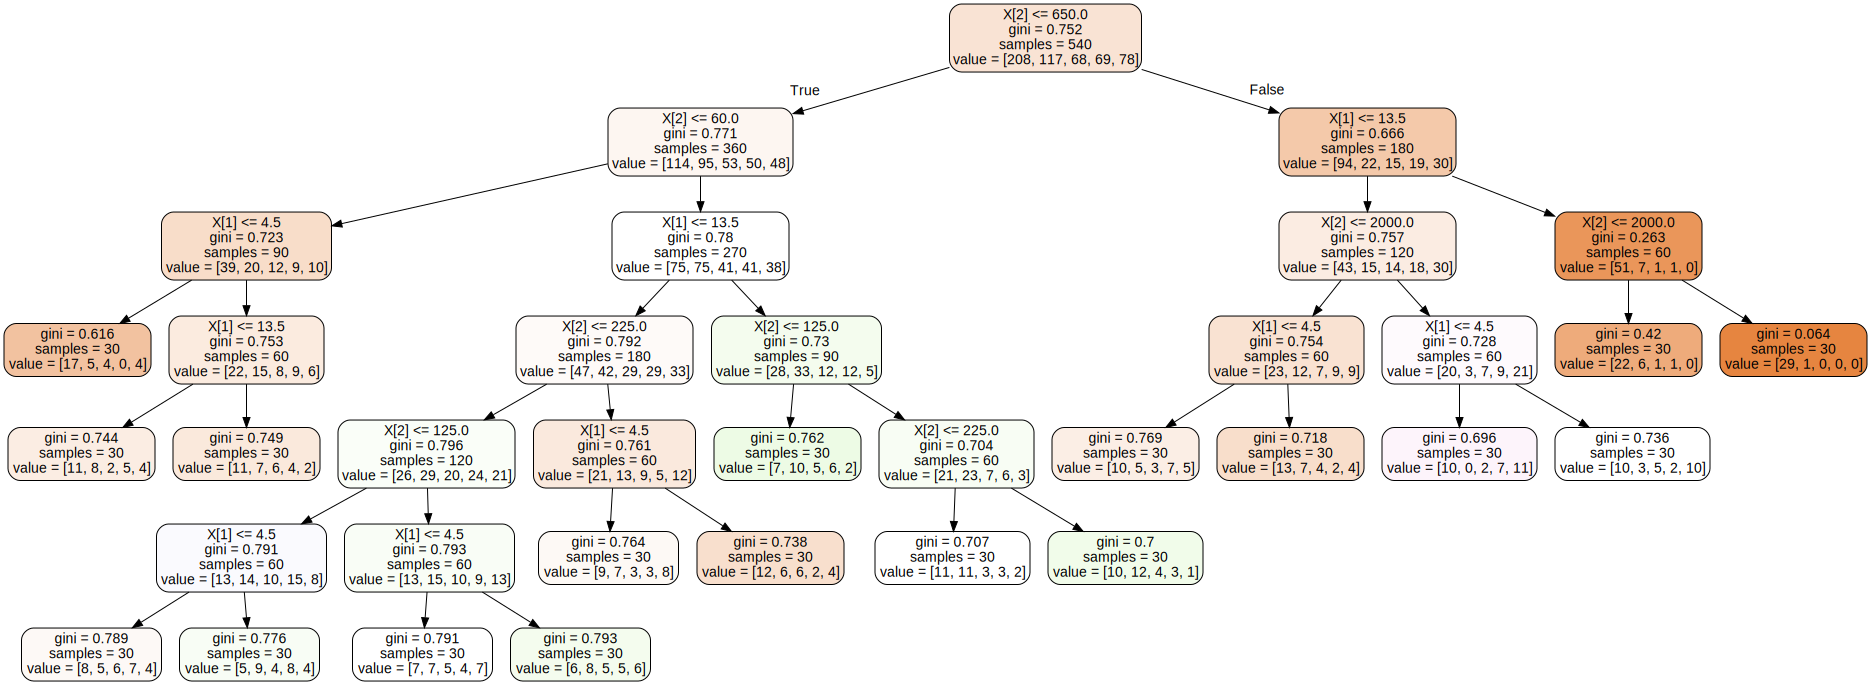

In [19]:
dot_data = sklearn.tree.export_graphviz(cm.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [15]:
alg_list[0].error(train_set[0])

0.65

In [16]:
cm.alg_perfs

AttributeError: 'DTChoice' object has no attribute 'alg_perfs'

In [ ]:
cm.model.dtree.best_col

In [ ]:
cm.alg_perfs.mean(axis=0)

In [ ]:
test_set = []
for c in [7]:
    for r in [20, 100]:
        for ratio in [0.5]:
            G = gen_data(low=0, high=1, ncol=c, nrow=2*r, y_ratio=ratio, seed=12345)
            X = G[:, 0:c]
            y = G[:, c]
            test_set.append(DB(X, y, 0.5, 0.2))
            
            
            

In [ ]:
[cm.mkChoice(t) for t in test_set]

In [ ]:
#Make an analysis tool
pd.concat([cm.alg_perfs, cm.mf_eval], axis=1).sort_values(['nrow', 'ncol'])

In [ ]:
cm.model.dtree.children[0].children[0].pred

In [ ]:
cm.model.dtree.children[0].children[1].pred

In [ ]:
cm.model.dtree.children[1].children[0].pred

In [ ]:
cm.model.dtree.children[1].children[1].pred

In [ ]:
cm.model.dtree.children[0].best_col

In [ ]:
cm.model.dtree.children[1].best_col